### Forecast experiment 4 - Store sales data forecast

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import keras
import seaborn as sns

# in time series forecasting, we usually need to scale our values
# for better end results
from sklearn.preprocessing import MinMaxScaler

In [2]:
# let's try a pandas DataFrame instead
df = pd.read_csv("RSCCASN.csv")

In [3]:
# filter the first years

In [4]:
# filtering only a part of the data
df = df.iloc[0:336]

In [5]:
df

,DATE,RSCCASN
0,1992-01-01,6938.0
1,1992-02-01,7524.0
2,1992-03-01,8475.0
3,1992-04-01,9401.0
4,1992-05-01,9558.0
...,...,...
331,2019-08-01,23830.0
332,2019-09-01,19550.0
333,2019-10-01,21388.0
334,2019-11-01,25117.0


In [6]:
# for easier and more dynamic code, save the value column name here
value_column = 'RSCCASN'

**Before going any further, scale the values in our DataFrame**

In [7]:
# scale the values with MinMaxScaler so that we don't
# affect the distribution of data (thus making the signal not realistic anymore)
# MinMaxScaler is a good solution here
scaler = MinMaxScaler()
df[[value_column]] = scaler.fit_transform(df[[value_column]])

# as weird as it sounds, scaling the index/sequence number also
# to be a decimal might affect the performance of the network
df = df.drop("DATE", axis=1)
df.index = df.index * 0.1 + 1

In [8]:
df

,RSCCASN
1.0,0.000000
1.1,0.020764
1.2,0.054461
1.3,0.087272
1.4,0.092835
...,...
34.1,0.598540
34.2,0.446885
34.3,0.512012
34.4,0.644143


In [9]:
# let's figure out a good cutoff point for train/test
# 67% for training, 25% testing (NOTE: you should experiment on this to find optimal %)
cutoff = int(len(df) * 0.8)

# train data
X_train = df.index[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df[value_column].iloc[cutoff:]

# convert everything into NumPy -array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# in this case, number of variables is 1 => scaled passengers value
n_features = 1

# use reshape tools to get the data ready for future use
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))


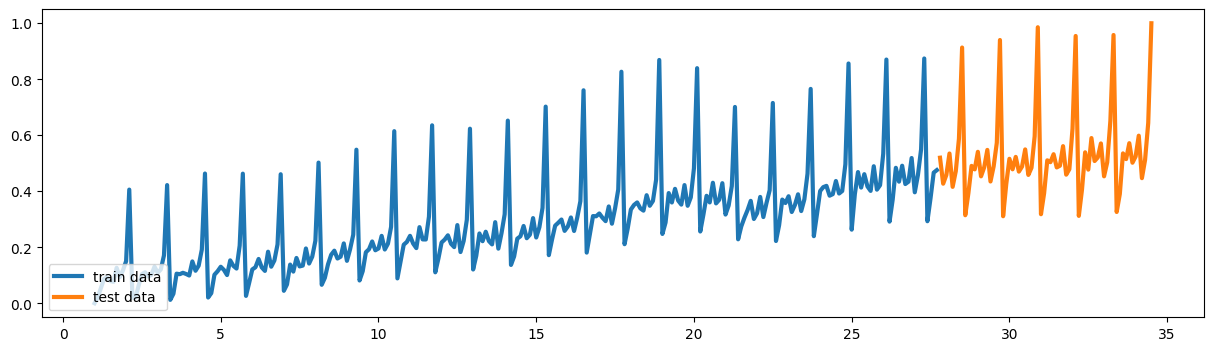

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# the variable that determines how many points
# back into the past the model attempts to learn

# due to this dateset being monthly sales for each year
# 12 is probably a good look_back so it captures one year of trends
# at a time
look_back  = 12
batch_size = 1

# stride = 1 => means we use separate time steps
# more than 1 => we use windowing

# TimeseriesGenerators were deprecated by TensorFlow developers
# during October 2024
# this means, in some unknown future TensorFlow -version
# this feature will removed
# check the other version of this notebook on how to replace
# TimeseriesGenerator with a TensorFlow Dataset
train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

In [12]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model_sales_forecast.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

# build the neural network
# in this case, LSTM with 8 neurons
n_neurons  = 32

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
model.add(LSTM(n_neurons, activation="relu"))

# if you wish to use multiple layers of LSTM or RNN in the same network
# you have to use the return_sequences=True in every other RNN/LSTM-layer
# EXCEPT THE LAST ONE BEFORE OUPUT
# model.add(LSTM(16, activation="relu", return_sequences=True))

# model.add(Dense(16, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# it's not optimal to use test data as validation data
# because this might skew our metrics
# see the other version of this notebook on how to do
# train/validation/test -split for the sine wave
model.fit(train_generator, epochs=50, verbose=1, validation_data=test_generator, callbacks=callback_list)


Epoch 1/50


c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0228 - val_loss: 0.0272
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0178 - val_loss: 0.0253
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - val_loss: 0.0137
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091 - val_loss: 0.0164
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0109
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 9/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 10/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 11/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 12/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

**Training metrics**

<Axes: >

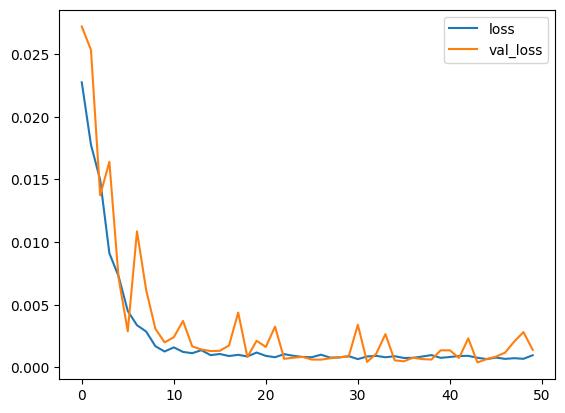

In [13]:
# the usual training metrics visualization
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [14]:
# reload the best version of the model
from keras.models import load_model
model = load_model("best_model_sales_forecast.keras")

In [15]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# these values are very close to each other, 
# which means our model is quite optimal
# IN THEORY 

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 5.7658e-04
Training loss: 0.000576582329813391
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 3.8715e-04
Testing loss: 0.00038715271512046456


**Test predictions**

In [16]:
test_predictions  = model.predict(test_generator)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


**Conventional regression metrics + MAPE**

In [17]:
# let's make a separate copy of the test values
# so we can calculate some errors

actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
3.26 %

MAE
0.02 units

MSE
0.0 units^2

RMSE:
0.02 units

R-squared:
0.98


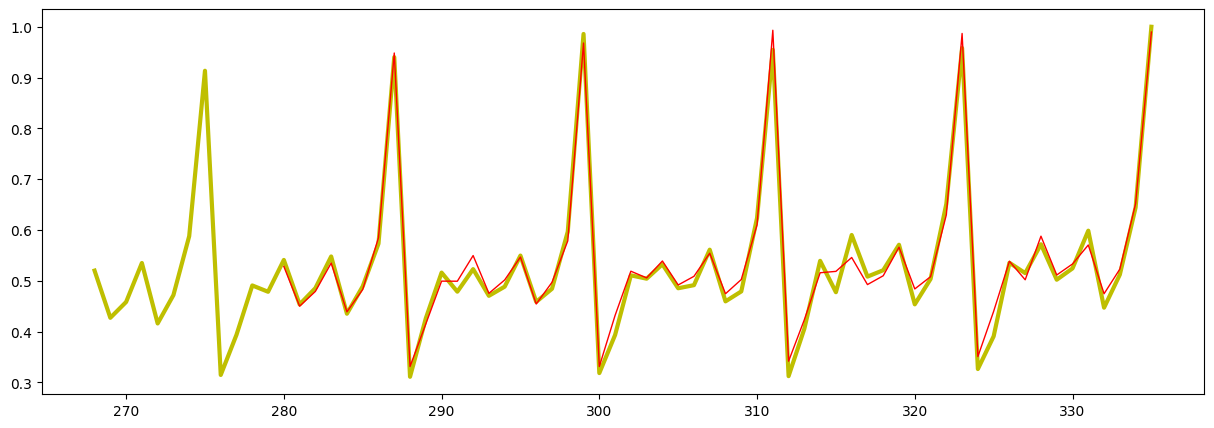

In [18]:
# calculate helper x-variables for where the train data starts
# where the test data starts and where the predictions start
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

In [19]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# some difference here which we can see in the test-signal prediction already 

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7658e-04
Training loss: 0.000576582329813391
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8715e-04
Testing loss: 0.00038715271512046456


**Extrapolation into the future**

In [20]:
# EXTRAPOLATION TEST 1 - 180 new points
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(120):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

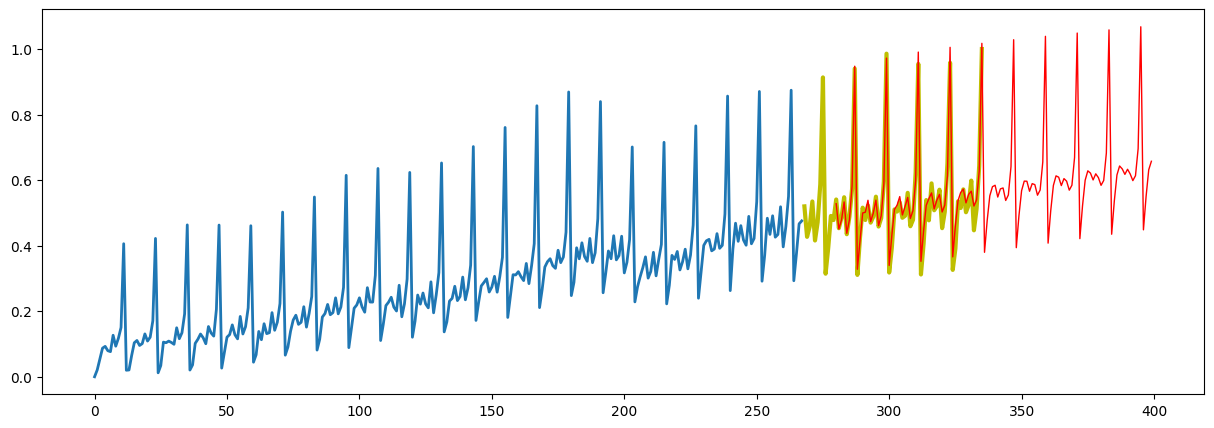

In [21]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

 It's viable to also inspect deviation and variance in order to numerically verify if the extrapolation is realistic or not. The most important thing is to detect if the extrapolation shrinks or explodes towards the sky.

In [22]:
df_extra = pd.DataFrame(data=extrapolation)

In [23]:
df_extra.describe()

,0
count,120.000000
mean,0.582752
std,0.150553
min,0.328072
25%,0.507151
50%,0.561609
75%,0.609847
max,1.067878


In [24]:
df_extra.var()

0    0.022666
dtype: float32

**Additional thoughts:**

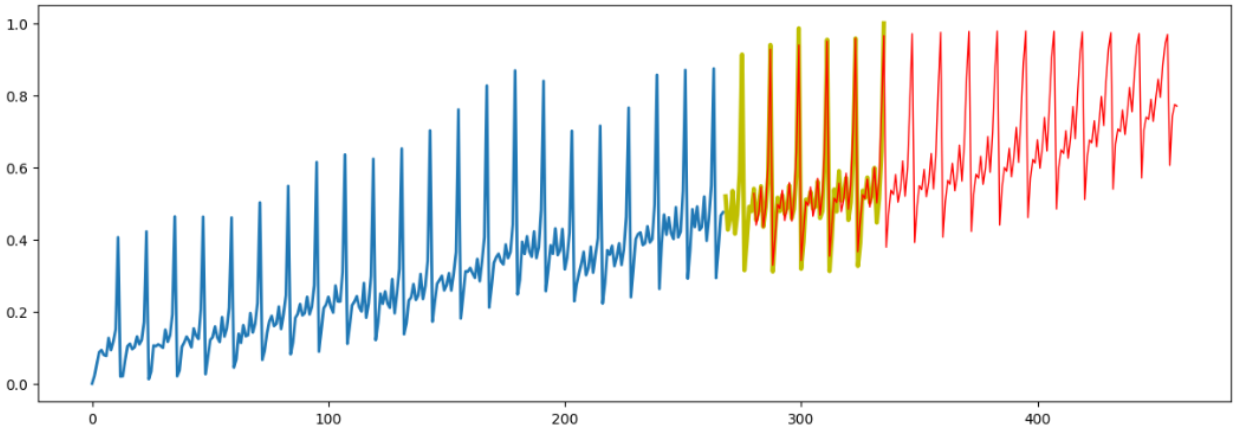

With LSTM 32 nodes + Dense 16 nodes created a pretty okay forecast, although it shrinks a bit towards the far future.

In reality, the data followed this trend:

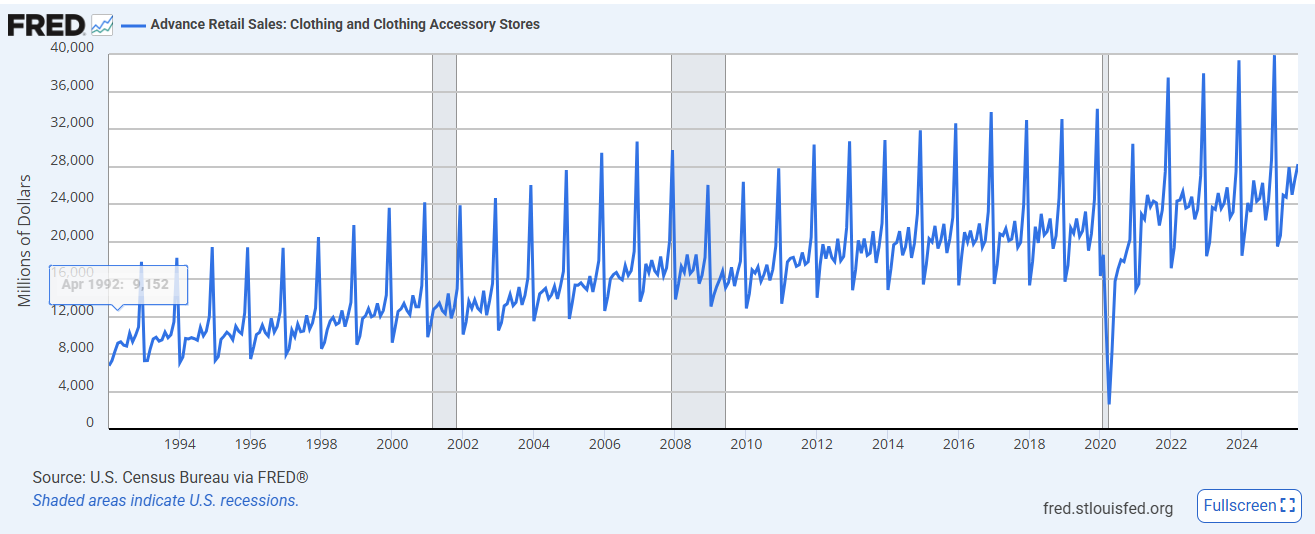

https://fred.stlouisfed.org/series/RSCCASN

COVID-19 was completely unpredictable at the time, and forecasting models can only capture trends from past data. Forecasting models can't exactly "predict the future", only create a trend -based guesstimation based on earlier trends.